In [1]:
import os
from typing import List

import numpy as np
import matplotlib.pyplot as plt

os.makedirs('./results', exist_ok=True)

with open('./brown_100.txt', 'r') as file_:
    corpus = file_.read()

def write_freqs(list_: list, filename: str) -> None:
    with open(f'./results/{filename}.txt', 'w') as file_:
        file_.write('\n'.join([' '.join(x[0]) + ' | ' + str(x[1]) for x in list_]))

## N-Gram Language Modeling
In the second assignment, you will implement an **n-gram language model** that processes input text to generate, analyze, and calculate the probabilities of sequences of `n` words (n-grams). This model will tokenize text, create n-grams, and compute their frequencies and probabilities, returning the most frequent n-grams in the text.

1. **Tokenization**: Convert the input text into a list of words (tokens).
2. **N-gram Generation**: Create sequences of `n` tokens from the text, treating each sentence independently with the inclusion of start (`<s>`) and end (`</s>`) markers.
3. **Frequency Counting**: Count how many times each n-gram appears in the text.
4. **Probability Calculation**: Compute the probabilities of each n-gram based on its frequency and add alpha smoothing to improve generalization of items.
5. **Most Frequent N-grams**: Return the most frequent n-grams along with their probabilities, helping to identify common patterns in the text.

In [2]:
from typing import Tuple
import re
from collections import Counter, defaultdict # You may import more from collections if needed

class NGramModel:
    def __init__(self, text, n, alpha=0.0):
        """
        Initialize the NGramModel with text and the value of n.
        """
        self.text = text
        self.n = n
        self.alpha = alpha  # Alpha value for additive smoothing
        self.ngrams = defaultdict(int)
        self.probabilities = {}
        self.vocab = set()

        #For generate n_grams:
        #token_list = the list of sentences where each sentence is a list of tokens
        self.token_list = []

        #For calculating the conditional probability of ngrams when n >= 2
        self.unigrams = Counter()
        self.bigrams = Counter()

    def tokenize(self) -> List[str]:
        """
        Tokenize the text into words.
        Fill in the code to split the text into a list of words.
        """

        text =self.text.splitlines()
        tokens = []
        for line in text:
            # we change all the tokens to lowercases here
            tokens_per_line = list(map(lambda x: x.lower(), line.strip().split(" ")))
            self.token_list.append(tokens_per_line)
            tokens += tokens_per_line
        # print(tokens)
        # print("==" * 20)
        # print(self.token_list)
        self.vocab = set(tokens)
        return tokens

    def generate_ngrams(self, tokens: list) -> dict:
        """
        Generate n-grams from the list of tokens.
        Fill in the code to create n-grams.
        Make sure to treat each sentence independently, include the <s> and </s> tokens.
        """
        for tokens in self.token_list:
            for token in range(0, len(tokens) - self.n + 1):
                self.ngrams[tuple(tokens[token:token + self.n])] += 1
        return self.ngrams

    def count_frequencies(self) -> None:
        """
        Count the frequencies of unigrams and bigrams
        which will be used in calculating the conditional probabilities of each n-gram when n >= 2
        """
        self.unigrams = Counter(token for tokens in self.token_list for token in tokens)
        self.bigrams = Counter(pair for tokens in self.token_list for pair in zip(tokens, tokens[1:]))

    def calculate_probabilities(self) -> None:
        """
        Calculate probabilities of each n-gram based on its frequency. Add alpha smoothing separately.
        """
        total_ngrams = sum(self.ngrams.values())
        vocab_size = len(self.vocab)

        '''
        1. When we are calculating unigrams or calculating the calculate the probabilities without smoothing,
        we calculate probabilities of each n-gram based on its frequency;

        2. when n >= 2 and we are applying smoothing to each n-gram, we use conditional probabilities:
        the formula used is based on the the chapter in SLP on N-Gram Language Models, which is provided in the spec.
        P(w_1:w_n) = ∏ P_Add-k(w_k|w_k−1), where k = [1, n]
        P_Add-k(w_n|w_(n−1)) = (C(w_(n−1), w_n) + k) / (C(w_(n−1)) + k * V), where k = self.alpha and V = vocab_size.
        '''
        if self.n == 1 or self.alpha == 0.0:
            for ngram, count in self.ngrams.items():
                self.probabilities[ngram] = (count + self.alpha) / (total_ngrams + self.alpha * vocab_size)
        else:
            for ngram, _ in self.ngrams.items():
                # print(ngram)
                pairs = [pair for pair in zip(ngram, ngram[1:])]

                # if ngram == ('the', 'jury'):
                #     print(pairs)
                #     print(self.unigrams['the'])
                #     print(self.bigrams[('the', 'jury')])

                probs = [(self.bigrams[token1, token2] + self.alpha)
                         / (self.unigrams[token1] + self.alpha * vocab_size) for token1, token2 in pairs]

                # if ngram == ('the', 'jury'):
                #     print(probs)

                for i, prob in enumerate(probs):
                    if i == 0:
                        self.probabilities[ngram] = prob
                    else:
                        self.probabilities[ngram] *= prob

    def most_frequent_ngrams(self, top_n: int = 10) -> list:
        """
        Return the most frequent n-grams and their probabilities.
        """

        sorted_grams = sorted(self.probabilities.items(), key=lambda item: item[1], reverse=True)
        return sorted_grams[:top_n]

# Testing the model with an example
text = "This is a simple example to demonstrate how n-grams work in this assignment." #Faster than running the full corpus
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(text, n)

tokens = model.tokenize()
print(tokens)
ngrams = model.generate_ngrams(tokens)

model.count_frequencies()
model.calculate_probabilities()

# Print the most frequent n-grams
print(model.most_frequent_ngrams(10))

['this', 'is', 'a', 'simple', 'example', 'to', 'demonstrate', 'how', 'n-grams', 'work', 'in', 'this', 'assignment.']
[(('this', 'is'), 0.08333333333333333), (('is', 'a'), 0.08333333333333333), (('a', 'simple'), 0.08333333333333333), (('simple', 'example'), 0.08333333333333333), (('example', 'to'), 0.08333333333333333), (('to', 'demonstrate'), 0.08333333333333333), (('demonstrate', 'how'), 0.08333333333333333), (('how', 'n-grams'), 0.08333333333333333), (('n-grams', 'work'), 0.08333333333333333), (('work', 'in'), 0.08333333333333333)]


### Unigrams

In this section, we apply the `NGramModel` to our corpus. The model can be configured to generate unigrams, bigrams, or trigrams by adjusting the value of `n`. After tokenizing the text and generating the n-grams, the model counts the occurrences of each n-gram and calculates their probabilities. The most frequent n-grams are then written to an output file.

By adjusting the n-gram size, we can analyze different levels of word dependencies in the text, providing insights into common word sequences and patterns.  

The code below will generate unigrams when the NGramModel is implemented correctly

In [3]:
n = 1  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
print(model.probabilities[("all",)])
print(model.probabilities[("resolution",)])

most_freq = model.most_frequent_ngrams(10)
write_freqs(model.most_frequent_ngrams(10), 'unigrams')


0.0004051863857374392
0.003646677471636953


### Bigrams
Bigrams allow us to explore word pairs and their relationships, providing insight into common word combinations and phrase structures within the corpus.  
The code below will generate bigrams when the NGramModel is implemented correctly.

In [4]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

# print(model.probabilities[('all', 'the')])
print(model.probabilities[('the', 'jury')])
write_freqs(model.most_frequent_ngrams(10), 'bigrams')

0.005489864864864865


### Trigrams
Trigrams capture three-word sequences, providing a deeper understanding of longer word dependencies and commonly occurring phrases within the text.  
The code below will generate trigrams when the NGramModel is implemented correctly

In [5]:
n = 3  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
print(model.probabilities[('in', 'the', 'past')])

write_freqs(model.most_frequent_ngrams(10), 'trigrams')

0.0004409171075837742


### Smoothing
Below, we generate **bigrams** with **smoothing** applied by setting `n = 2` and including a smoothing parameter `alpha = 1.0`. Smoothing is useful in language models to handle unseen n-grams by assigning a small probability to them. The model tokenizes the text, generates bigrams, counts their frequencies, and calculates smoothed probabilities. The most frequent bigrams are then written to an output file.





In [6]:
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n, alpha=1.0)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams_smoothed')

### Generating Text
In this example, we generate text using the **bigrams** model by providing a starting **prompt** (e.g., "the jury"). The `generate_text` function creates a sequence of words based on the trained bigram model, starting from the provided prompt and continuing based on the probabilities of the next words.

After tokenizing the corpus, generating bigrams, and calculating their frequencies and probabilities, the model uses these learned probabilities to generate text. The generated output is then written to a file.

Text generation with n-grams helps illustrate how language models can predict word sequences, allowing us to create new sentences that follow similar patterns found in the original text.

In [7]:
import random


def generate_text(model: NGramModel, n: int, prompt: str, max_len: int = 50) -> str:
    generated_tokens = prompt.strip().split()
    current_token = generated_tokens[-(n-1):]
    i = 0

    while True:
        # Collect possible next words and their probabilities
        # for ngram, probability in model.probabilities.items():
        #     print(list(ngram[:n-1]))
        #     print(current_token)
        #     print(ngram[n-len(current_token)-1:n-1])
        next_word_candidates = [(ngram[-1], prob) for ngram, prob in model.probabilities.items()
                                if list(ngram[n-len(current_token)-1:n-1]) == current_token]
        print(current_token)
        print(next_word_candidates)
        '''
        we stop if the sentence exceeds the max_len or there are no more candidates
        '''
        if (not next_word_candidates) or i > max_len:
            break

        # best_candidate = max(next_word_candidates, key=lambda x: x[1])
        # print(best_candidate)
        #
        # # Unpack the best candidate tuple
        # best_word, best_prob = best_candidate
        #
        # generated_tokens.append(best_word)

         # Unpack words and probabilities
        words, probs = zip(*next_word_candidates)

        # Use random.choices to select based on the probabilities
        next_word = random.choices(words, probs, k=1)[0]
        print("next_word: ", next_word)

        generated_tokens.append(next_word)

        # Advance to the next state, remove the first token in current_tokens
        current_token = generated_tokens[-(n-1):]
        i += 1
        print(generated_tokens)
    return ' '.join(generated_tokens)

n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n, alpha=1.0)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
generated_text = generate_text(model, 2, 'the jury')
with open(f'./results/generated_bigrams_smoothing.txt', 'w') as file_:
    file_.write(generated_text)

n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()
generated_text = generate_text(model, 2, 'the jury')
with open(f'./results/generated_bigrams_unsmoothing.txt', 'w') as file_:
    file_.write(generated_text)

['jury']
[('said', 0.010830324909747292), ('further', 0.0024067388688327317), ('had', 0.0024067388688327317), ('commented', 0.0024067388688327317), ('.', 0.0024067388688327317), ('took', 0.0024067388688327317), ('also', 0.0024067388688327317), ('recommended', 0.0036101083032490976), ('did', 0.0024067388688327317), ('praised', 0.0024067388688327317)]
next_word:  had
['the', 'jury', 'had']
['had']
[('over-all', 0.0024509803921568627), ('been', 0.003676470588235294)]
next_word:  been
['the', 'jury', 'had', 'been']
['been']
[('charged', 0.0024390243902439024), ('under', 0.0024390243902439024), ('agreed', 0.0024390243902439024), ('mayor', 0.0024390243902439024), ('expected', 0.0024390243902439024), ('an', 0.0024390243902439024), ('consulted', 0.0024390243902439024)]
next_word:  an
['the', 'jury', 'had', 'been', 'an']
['an']
[('investigation', 0.002442002442002442), ('orderly', 0.003663003663003663), ('interim', 0.002442002442002442), ('amicable', 0.002442002442002442), ('assistant', 0.00244

## Word Vectors
Based on the Stanford course: https://web.stanford.edu/class/cs224n/

### Count based W2V
In this section, we use the previously trained **n-gram model** to calculate a **co-occurrence matrix**. A co-occurrence matrix shows how often words appear together within a specific context (in this case, bigrams), providing insights into word relationships in the corpus.

Steps:
1. **Tokenization and N-gram Generation**: We first tokenize the text and generate bigrams using the `NGramModel`.
2. **Vocabulary and Indexing**: The vocabulary is created from the unique tokens, and a word-to-index mapping is established.
3. **Co-occurrence Matrix**: Using the generated n-grams, we compute the co-occurrence matrix, where each entry represents how often two words occur together within the bigrams.

The co-occurrence matrix provides a numerical representation of word relationships, which is useful for tasks like word embeddings, semantic analysis, and understanding word associations.

In [8]:
# Since we already have a working ngram model, for the next part we can use the ngrams to calculate the co-occurences.
model = NGramModel(corpus, 2)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)

def create_co_matrix(ngrams: dict, vocab_size: int, word_to_index: dict) -> np.ndarray:
    # Initialize a zero matrix of size vocab_size x vocab_size
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=int)

    # Iterate over each n-gram and update the matrix based on co-occurrences
    for ngram, count in ngrams.items():
        if len(ngram) == 2:  # Assuming bigrams, adjust if necessary for other n-gram levels
            first_word, second_word = ngram
            # Get indices for the words
            row_idx = word_to_index[first_word]
            col_idx = word_to_index[second_word]
            # Increment the matrix position by the count of the n-gram
            co_matrix[row_idx, col_idx] += count
    return co_matrix

def co_matrix_value_counts(co_matrix: np.ndarray) -> None:
    non_zero_indices = np.nonzero(co_matrix)
    non_zero_values = co_matrix[non_zero_indices]
    non_zero_elems = list(zip(non_zero_indices[0], non_zero_indices[1], non_zero_values))
    print(non_zero_elems)

vocab = list(set(tokens))
vocab_size = len(vocab)

# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}
print(word_to_index)

# Generate the co-occurrence matrix
co_matrix = create_co_matrix(ngrams, vocab_size, word_to_index)

# Optionally, print the matrix or parts of it
# co_matrix_value_counts(co_matrix)

{'recommended': 0, 'appraisers': 1, 'making': 2, 'weekend': 3, 'brought': 4, 'friendly': 5, 'attorney': 6, 'work': 7, 'listed': 8, 'rep.': 9, 'real': 10, 'chairman': 11, 'major': 12, 'take': 13, "georgia's": 14, 'pass': 15, '$30': 16, 'fact': 17, 'provide': 18, 'harry': 19, 'september-october': 20, '$50': 21, 'thanks': 22, 'heavily': 23, 'pelham': 24, 'asked': 25, 'henry': 26, 'near': 27, 'remedy': 28, 'keeping': 29, 'like': 30, 'durwood': 31, 'post': 32, 'over-all': 33, 'scheduled': 34, 'rob': 35, 'laws': 36, 'on': 37, 'elaborate': 38, 'reelection': 39, 'possible': 40, 'son': 41, '$100': 42, 'of': 43, 'public': 44, 'pricing': 45, "mayor's": 46, 'highways': 47, 'campaign': 48, 'atlanta': 49, 'about': 50, 'occupation': 51, 'austin': 52, 'police': 53, 'school': 54, 'this': 55, 'seemed': 56, "''": 57, 'influences': 58, 'former': 59, 'distribute': 60, '18': 61, 'mental': 62, 'disproportionate': 63, 'also': 64, 'size': 65, 'sales': 66, '637': 67, 'new': 68, 'term': 69, 'byrd': 70, 'midnight

With the code below you can verify if the co-occurence works

In [9]:
def check_co_occurrence(word1, word2, co_matrix, word_to_index):
    """
    Print the co-occurrence count for a specific word pair.
    """
    if word1 not in word_to_index or word2 not in word_to_index:
        print(f"One or both words '{word1}' and '{word2}' are not in the vocabulary.")
        return

    index1 = word_to_index[word1]
    index2 = word_to_index[word2]

    co_count = co_matrix[index1][index2]
    print(f"Co-occurrence count for '{word1}' and '{word2}': {co_count}")

check_co_occurrence('the', 'jury', co_matrix, word_to_index)
check_co_occurrence('the', 'cat', co_matrix, word_to_index)

Co-occurrence count for 'the' and 'jury': 13
One or both words 'the' and 'cat' are not in the vocabulary.


In this part, we reduce the dimensionality of the **co-occurrence matrix** using **Singular Value Decomposition (SVD)**. This technique helps in extracting the most important features from the matrix, making it easier to visualize and interpret the relationships between words.

Steps:
1. **Singular Value Decomposition (SVD)**: The co-occurrence matrix is decomposed into three matrices: $\( M = U \cdot \Sigma \cdot V^T \)$.
2. **Dimensionality Reduction**: We retain only the top `k` components (default is 2) from the SVD, effectively reducing the dimensionality of the matrix.
3. **Reduced Matrix**: The reduced matrix retains the most important semantic information and can be used for tasks such as **word embedding visualization** or **semantic similarity analysis**.

Dimensionality reduction allows us to capture the essence of word relationships in fewer dimensions, making it more efficient to process and visualize the data.

In [10]:
import numpy as np
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD


def reduce_to_k_dim(M, k=2):
    """
    Reduce the dimensionality of a co-occurrence matrix using SVD.

    :param M: The co-occurrence matrix
    :param k: The number of dimensions to reduce to (default is 2)
    :return: The reduced matrix
    """
    # Step 1: Perform SVD
    # U, S, VT = svd(M, full_matrices=False)
    #
    # # Step 2: Dimensionality Reduction - retain the top k components
    # U_k = U[:, :k]  # Take the first k columns of U
    # S_k = np.diag(S[:k])  # Take the top k singular values and form a diagonal matrix
    # VT_k = VT[:k, :]  # Take the first k rows of VT
    #
    # # Step 3: Compute the reduced matrix (dot product of U_k and Sigma_k)
    # M_reduced = np.dot(U_k, S_k)
    # M_reduced = np.dot(U_k, np.dot(S_k, VT_k))

    #use TruncatedSVD to calculate the SVD
    svd = TruncatedSVD(n_components=k)
    M_reduced = svd.fit_transform(M)

    return M_reduced

# Example usage
# Assume co_matrix has been computed previously
# co_matrix = create_co_matrix(...)
reduced_matrix = reduce_to_k_dim(co_matrix, k=2)

# Print or use the reduced matrix
print("Reduced Matrix:\n", reduced_matrix)

Reduced Matrix:
 [[ 1.36738033e-04  2.09815171e-01]
 [ 1.35962053e-04  5.65293412e-03]
 [ 5.73869433e-06  1.52937112e-01]
 ...
 [-3.56388562e-22  5.69630824e-19]
 [ 3.10752583e-06  5.07775217e-02]
 [ 7.34424980e-25  4.70985315e-20]]


In this final part, we visualize the reduced word embeddings in **2D space**. After reducing the dimensionality of the co-occurrence matrix using SVD, we plot the embeddings for each word to observe their relationships in a low-dimensional space.

Steps:
1. **Plotting the Embeddings**: Each word from the vocabulary is plotted based on its 2D coordinates from the reduced matrix.
2. **Visualization**: The scatter plot allows us to see how words cluster together or relate to each other based on co-occurrences in the text. Words with similar contexts should appear closer to each other in the plot.
3. **Interpretation**: By looking at the 2D plot, we can analyze word similarities, relationships, and clusters formed by words that often occur together.

This visualization is a useful tool for understanding the structure of word embeddings and the relationships between words in the corpus.







{'jury': array([0.00040692, 0.17604381]), 'mayor': array([3.20211310e-06, 4.86256542e-02]), 'election': array([0.00120751, 0.09367453]), 'republicans': array([0.00025504, 0.04253906]), 'legislators': array([9.12717082e-06, 1.87537879e-01]), 'attorney': array([0.0003973, 0.0096386]), 'funds': array([0.00052763, 0.06304487]), 'highway': array([3.47834328e-08, 5.07379889e-03]), 'court': array([9.03584251e-06, 2.34780310e-01]), 'county': array([0.00013733, 0.02935304]), 'teacher': array([0.00013606, 0.00780691]), 'police': array([5.80040582e-09, 8.47620736e-04])}


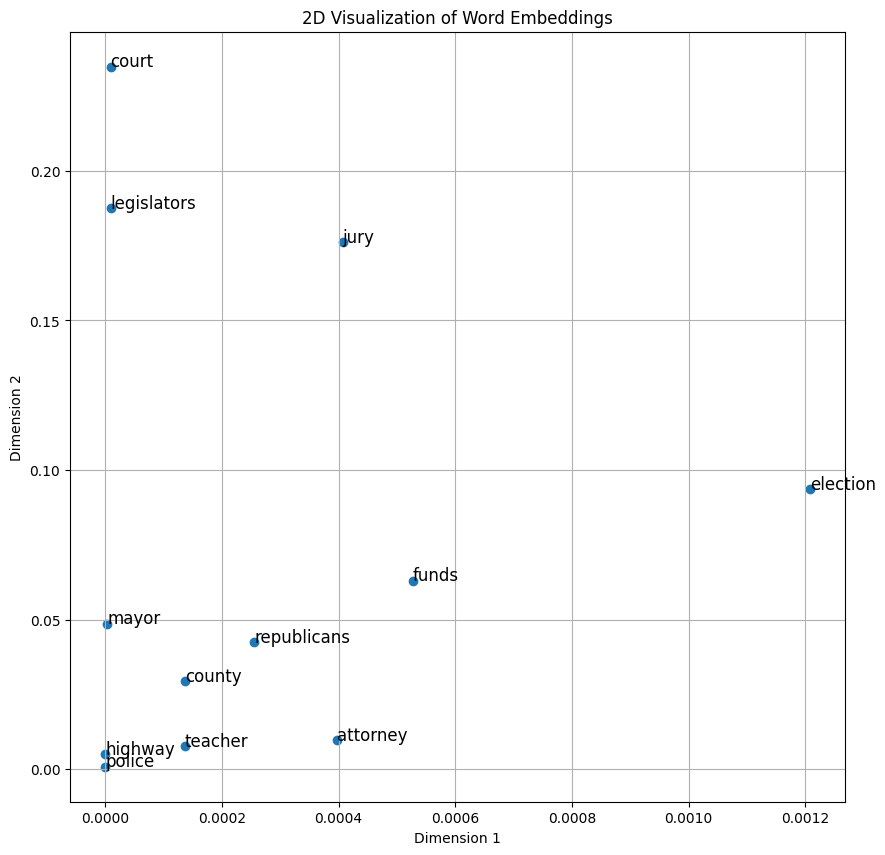

In [11]:
from typing import Dict


def plot_embeddings(M_reduced: np.ndarray, word_to_index: Dict[str, int], words: List[str]):
    """
    Plot word embeddings in 2D space.

    :param M_reduced: The reduced matrix containing the 2D coordinates for words
    :param word_to_index: The vocabulary corresponding to the embeddings
    :param words: A list of words to plot
    """
    # Create a dictionary to map words to their embeddings
    # for word in words:
        # print(M_reduced[1])
        # print(word_to_index[word])
    word_to_vector = {word: M_reduced[word_to_index[word]] for word in words if word in word_to_index}
    print(word_to_vector)

    # Extract the coordinates for plotting
    coordinates = np.array(list(word_to_vector.values()))

    # Create a scatter plot
    plt.figure(figsize=(10, 10))
    plt.scatter(coordinates[:, 0], coordinates[:, 1])

    # Annotate each point with the corresponding word
    for i, word in enumerate(word_to_vector.keys()):
        plt.annotate(word, (coordinates[i, 0], coordinates[i, 1]), fontsize=12)

    plt.title("2D Visualization of Word Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

# words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']
words =   ['jury', 'mayor', 'election', 'republicans', 'legislators', 'attorney', 'funds', 'highway', 'court', 'county',
           'teacher', 'police']

vocab = list(set(tokens))
# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}
reduced_M = reduce_to_k_dim(co_matrix, k=2)

plot_embeddings(reduced_M, word_to_index, words)

## Prediction-Based Word Vectors
In this section, we load pre-trained word vectors using the **GloVe** embeddings from the [Stanford NLP paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf). The pre-trained embeddings provide rich semantic information about words based on large text corpora, allowing us to represent words as vectors that capture their meaning and relationships.

Steps:
1. **Load GloVe Word Vectors**: We use the GloVe embeddings from the `glove-wiki-gigaword-200` model, which has 200-dimensional vectors for each word.
2. **Vocabulary Matching**: We map the words from our corpus to the GloVe vocabulary and extract the corresponding vectors.
3. **Dimensionality Reduction**: After obtaining the word vectors, we reduce the dimensionality to visualize the embeddings in 2D space, allowing us to explore word relationships visually.

This is an excellent opportunity to explore how pre-trained embeddings like GloVe can be used to improve downstream NLP tasks by providing richer word representations.

In [12]:
from gensim.models import Word2Vec
# Do not edit
import gensim.downloader as api
import numpy as np
from gensim.models import KeyedVectors

#the api is not compatiable with python11, so we manually load the corpus here
wv_from_bin = KeyedVectors.load("glove-wiki-gigaword-200.model")
print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

wv_words = list(wv_from_bin.index_to_key)
unique_tokens = set(tokens)
word2ind = {}
M = []
idx = 0

print('rendering M based on wv')
for w in wv_words:
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass

print(idx)
print('rendering M based on unique_tokens')
for w in unique_tokens:
    if w in wv_words:
        continue
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass
print(idx)

M = np.stack(M)
M_reduced = reduce_to_k_dim(M, k=2)

M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

Loaded vocab size 400000
rendering M based on wv
400000
rendering M based on unique_tokens
400000


### Compare plots
What stands out when comparing the two different ways of embedding using the given words?

(Use this to help answer the question in your assignment document).

{'jury': array([ 0.9986267 , -0.05238989], dtype=float32), 'mayor': array([ 0.78648525, -0.6176091 ], dtype=float32), 'election': array([ 0.99999577, -0.00290835], dtype=float32), 'republicans': array([0.98090535, 0.19448566], dtype=float32), 'legislators': array([0.9826049 , 0.18570817], dtype=float32), 'attorney': array([ 0.6813541, -0.7319539], dtype=float32), 'funds': array([0.9700725 , 0.24281536], dtype=float32), 'highway': array([0.95943815, 0.28191915], dtype=float32), 'court': array([ 0.9944885 , -0.10484613], dtype=float32), 'county': array([ 0.99696857, -0.07780526], dtype=float32), 'teacher': array([ 0.91798526, -0.3966144 ], dtype=float32), 'police': array([ 0.976609  , -0.21502301], dtype=float32)}


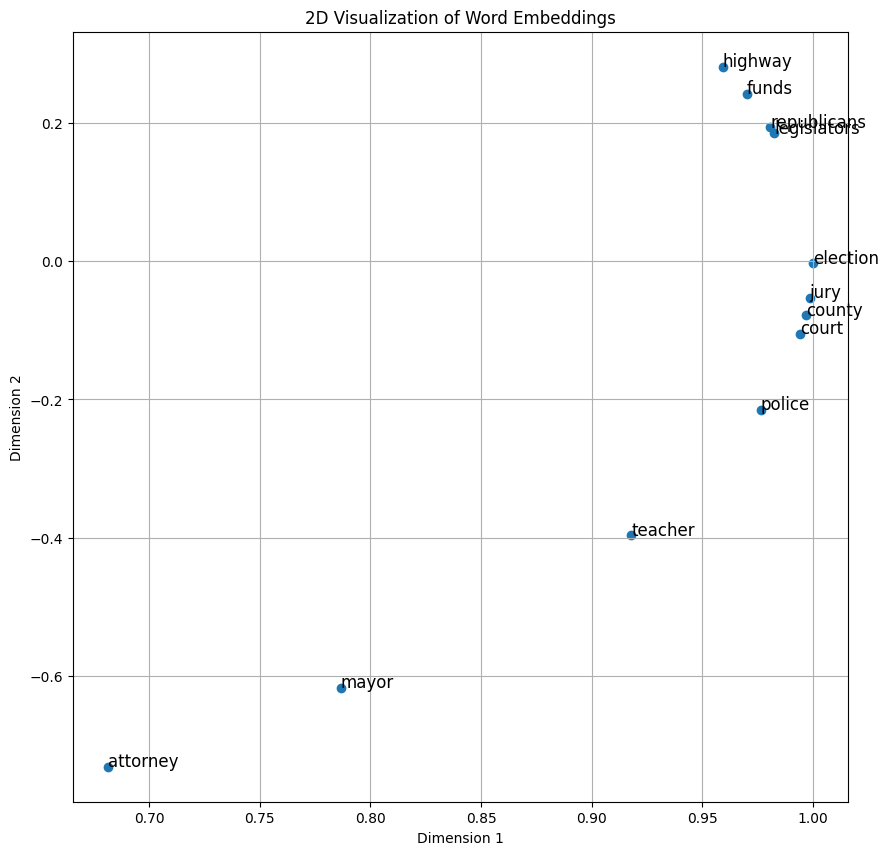

{'jury': array([0.00040692, 0.17604381]), 'mayor': array([3.20211310e-06, 4.86256542e-02]), 'election': array([0.00120751, 0.09367453]), 'republicans': array([0.00025504, 0.04253906]), 'legislators': array([9.12717082e-06, 1.87537879e-01]), 'attorney': array([0.0003973, 0.0096386]), 'funds': array([0.00052763, 0.06304487]), 'highway': array([3.47834328e-08, 5.07379889e-03]), 'court': array([9.03584251e-06, 2.34780310e-01]), 'county': array([0.00013733, 0.02935304]), 'teacher': array([0.00013606, 0.00780691]), 'police': array([5.80040582e-09, 8.47620736e-04])}


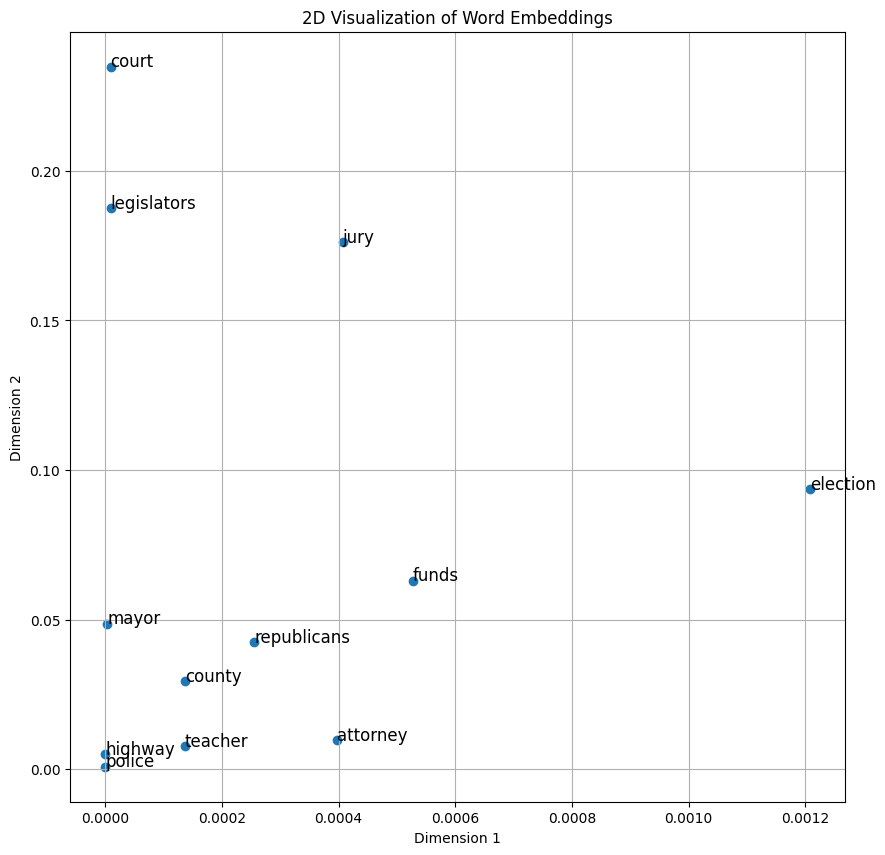

In [13]:

# plot_embeddings(M_reduced, word2ind, words)
'''
we compare the normalized embeddings with the original embeddings we get from brown-100.txt
'''
plot_embeddings(M_reduced_normalized, word2ind, words)
plot_embeddings(reduced_M, word_to_index, words)

### Words with multiple meanings
Polysemes and homonyms are words that have more than one meaning (see [this wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms). Your task is to find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings.

For example:
- "leaves" has both the "go_away" and "a_structure_of_a_plant" meanings in the top 10.
- "scoop" has both "handed_waffle_cone" and "lowdown" meanings in the top 10.

You will probably need to try several polysemous or homonymic words before you find one.

Once you discover a word that fits this criterion, state the word and explain the multiple meanings that occur in the top 10. Reflect on why many of the polysemous or homonymic words you tried didn’t work (i.e., why the top-10 most similar words only contain one of the word's meanings).

**Note**: Use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary based on their cosine similarity to the given word. For further assistance, you can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [14]:
## Your code here
wv_words = list(wv_from_bin.index_to_key)
print(wv_from_bin.most_similar('light'))
print()
print(wv_from_bin.most_similar('bank'))
print()
print(wv_from_bin.most_similar('match'))

[('bright', 0.6242774128913879), ('dark', 0.6141001582145691), ('lights', 0.6013951897621155), ('lighter', 0.558175265789032), ('heavy', 0.5408364534378052), ('sunlight', 0.5362918376922607), ('blue', 0.5349379777908325), ('colored', 0.5282376408576965), ('sky', 0.5239452719688416), ('color', 0.513929009437561)]

[('banks', 0.7625691294670105), ('banking', 0.6818838119506836), ('central', 0.6283639073371887), ('financial', 0.6166561841964722), ('credit', 0.6049751043319702), ('lending', 0.5980607867240906), ('monetary', 0.5963001847267151), ('bankers', 0.5913101434707642), ('loans', 0.5802939534187317), ('investment', 0.574020266532898)]

[('matches', 0.8782557845115662), ('tournament', 0.711606502532959), ('final', 0.6953871250152588), ('semifinal', 0.6713098883628845), ('quarterfinal', 0.6652303338050842), ('play', 0.6628587245941162), ('draw', 0.6566704511642456), ('game', 0.6471269130706787), ('champions', 0.6443206667900085), ('finals', 0.6381971836090088)]


General Failures:

Many polysemous words may fail in this task if their embeddings lean strongly towards one meaning based on corpus data. For example, a word like "bark" could predominantly reflect "tree bark" in specific contexts, leading to similar words being restricted to that context only.

### Synonyms
When considering **Cosine Similarity**, it's often useful to think of **Cosine Distance**, which is simply 1 - Cosine Similarity.

Find three words \( (w_1, w_2, w_3) \) where:
- \(w_1\) and \(w_2\) are **synonyms**.
- \(w_1\) and \(w_3\) are **antonyms**.

However, you need to find a case where **Cosine Distance** $\( (w_1, w_3) < \text{Cosine Distance} (w_1, w_2) \)$. In other words, the antonym is **closer** to the word than its synonym in the vector space.

For example, "happy" (\(w_1\)) may be closer to "sad" (\(w_3\)) than to "cheerful" (\(w_2\)), which is counter-intuitive since we expect synonyms to be closer than antonyms. 

Once you find such an example, provide a possible explanation for why this result may have occurred.

Use the `wv_from_bin.distance(w1, w2)` function to compute the cosine distance between two words. You can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for further assistance.







In [15]:
## Your code here
#synonyms: tongyici
#antonyms: fanyici

w1 = 'large'      # The main word
w2 = 'big'        # Synonym
w3 = 'small'      # Antonym

distance_w1_w2 = wv_from_bin.distance(w1, w2)  # Synonym distance
distance_w1_w3 = wv_from_bin.distance(w1, w3)  # Antonym distance

print(f"Cosine Distance (w1: {w1}, w2: {w2}): {distance_w1_w2}")
print(f"Cosine Distance (w1: {w1}, w3: {w3}): {distance_w1_w3}")

# Analyze results
if distance_w1_w3 < distance_w1_w2:
    print(f"right ans: The antonym '{w3}' is closer to '{w1}' than the synonym '{w2}'.")
else:
    print(f"wrong ans: The synonym '{w2}' is closer to '{w1}' than the antonym '{w3}'.")

Cosine Distance (w1: large, w2: big): 0.33401328325271606
Cosine Distance (w1: large, w3: small): 0.1497916579246521
right ans: The antonym 'small' is closer to 'large' than the synonym 'big'.


### Analogies
Word vectors have demonstrated the ability to solve analogies based on their learned semantic relationships. For instance, consider the analogy: 

**"man : grandfather :: woman : x"** 

(Read: man is to grandfather as woman is to x). Using word vectors, we can find the word \(x\) that completes the analogy.

In the example provided, we use the `most_similar` function from the Gensim library. This function identifies words that are most similar to the words in the positive list and most dissimilar to those in the negative list. For analogy solving, it effectively computes:

$\[ \text{word}(x) = \text{most similar to} (\text{woman} + \text{grandfather} - \text{man}) \]$

The result is the word with the highest cosine similarity to the target vector. You can use this approach to explore various analogies and gain insights into the semantic structure of word vectors.

Refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for more details on the `most_similar` function and how word vectors handle analogy-solving tasks.

In [16]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
print(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793), ('granddaughter', 0.7200807332992554), ('daughter', 0.7168302536010742), ('mother', 0.7151536345481873), ('niece', 0.7005681395530701), ('father', 0.6659888029098511), ('aunt', 0.6623408794403076), ('grandson', 0.6618767380714417), ('grandparents', 0.6446609497070312), ('wife', 0.6445354223251343)]


man : grandfather :: woman : grandmother

### Bias in word vectors
a. **Observation**: Consider the results of a word vector model when queried with analogies involving "man", "woman", and "profession". What are the top results returned by the model for each query?

1. 'reputation', 'professions', 'skill', 'skills', 'ethic', 'business', 'respected', 'practice', 'regarded', 'life'
2. 'professions', 'practitioner', 'teaching', 'nursing', 'vocation', 'teacher', 'practicing', 'educator', 'physicians, 'professionals'

b. **Analysis**: Do you observe any gender biases in the results? For example, are certain professions more closely associated with "man" or "woman" based on the word vectors? Discuss how word embeddings might perpetuate societal biases present in the training data.

1. Professions Associated with Men and Women:
In the first query involving "man," the results feature general professional terms like "reputation," which are broader and less gender-specific. However, they are dominated by words related to skills and attributes, suggesting a focus on professional qualities.
In the second query involving "woman," many results explicitly point towards professions traditionally associated with women, such as "nursing" and "teaching." The appearance of these specific professions suggests that the embedding captures societal norms that typically associate these roles with women.
2. Bias Representation:
The difference in responses demonstrates that the embeddings reflect societal biases and stereotypes regarding gender and professions. Professions like "nursing" and "teaching" have a historical bias towards women, while the results associated with "man" do not feature male-specific professions but general professional attributes.
This discrepancy can undermine the equality and fairness expected in linguistic representations, perpetuating gender stereotypes.

c. **Reflection**: How might such biases affect the fairness of machine learning models that use word embeddings? Suggest potential strategies for mitigating gender bias in word vector models.

1. Impact on Machine Learning Models:
Such biases in word embeddings can lead to unfair outcomes in various natural language processing applications, including:
Recruitment Systems: If a model trained on biased embeddings indicates a lower likelihood for positions traditionally held by one gender, it could negatively impact hiring practices.
Sentiment Analysis: Associating negative sentiments with female-associated professions or attributes can skew the results of sentiment analysis toward gender bias.
2. Strategies for Mitigating Gender Bias:
Debiasing Techniques: Implement algorithms designed to reduce bias in embeddings after training. Techniques like post-processing the embeddings using methods such as the Hard Debiasing algorithm can help mitigate biases.
Balanced Training Data: Ensuring diversity and balance in the training dataset can help create fairer embeddings, avoiding reinforcing societal biases.
Regular Audits and Evaluations: Regularly analyzing models for biased outputs and addressing them proactively can help maintain fairness.
Contextualized Embeddings: Using context-aware models, like transformers (e.g., BERT), can help capture meanings more nuancedly than static word vectors, potentially alleviating some biases.
Educating Stakeholders: Raising awareness among data scientists and engineers about the implications of bias in embeddings can promote better practices and designs.


In [17]:
print(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176191329956), ('professions', 0.5178037881851196), ('skill', 0.49046966433525085), ('skills', 0.49005505442619324), ('ethic', 0.4897659420967102), ('business', 0.487585186958313), ('respected', 0.4859202802181244), ('practice', 0.48210465908050537), ('regarded', 0.4778572916984558), ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144), ('practitioner', 0.4988412857055664), ('teaching', 0.48292139172554016), ('nursing', 0.48211798071861267), ('vocation', 0.4788966476917267), ('teacher', 0.47160348296165466), ('practicing', 0.4693780839443207), ('educator', 0.4652431905269623), ('physicians', 0.46289944648742676), ('professionals', 0.4601393938064575)]
